## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

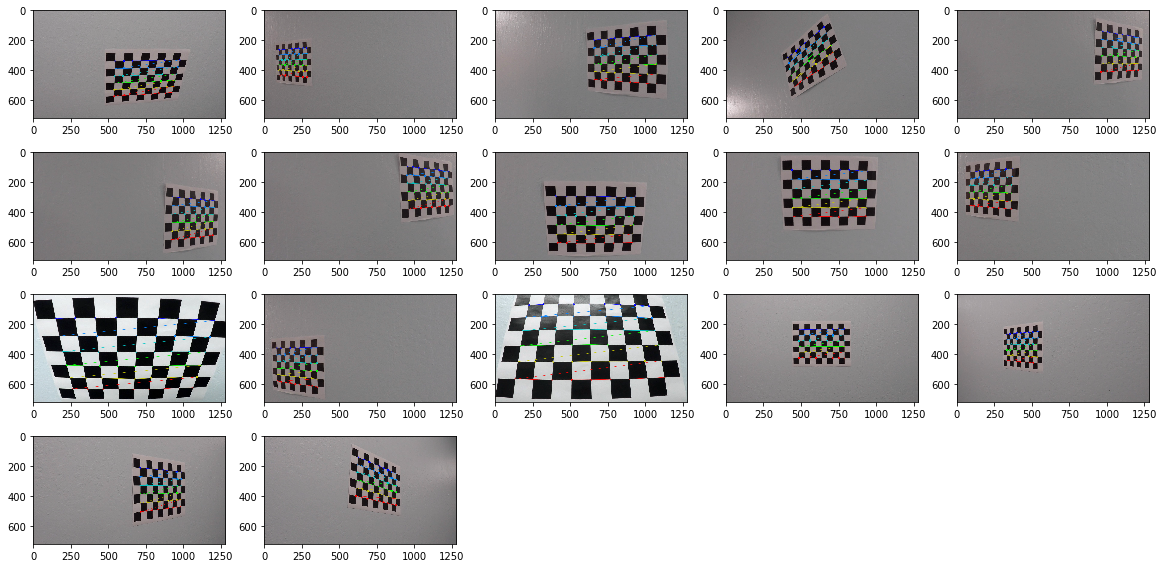

In [34]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
#%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
file_path = os.getcwd()
file_path = file_path + '/camera_cal/calibration*.jpg'
images = glob.glob(file_path)

plt.figure(figsize=(20,10))
# Step through the list and search for chessboard corners
i=1
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)
        plt.subplot(4,5,i)
        plt.imshow(img)        
        i=i+1
plt.show()

#cv2.destroyAllWindows()

## Apply a distortion correction to raw images.


In [121]:
def undistort_image(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

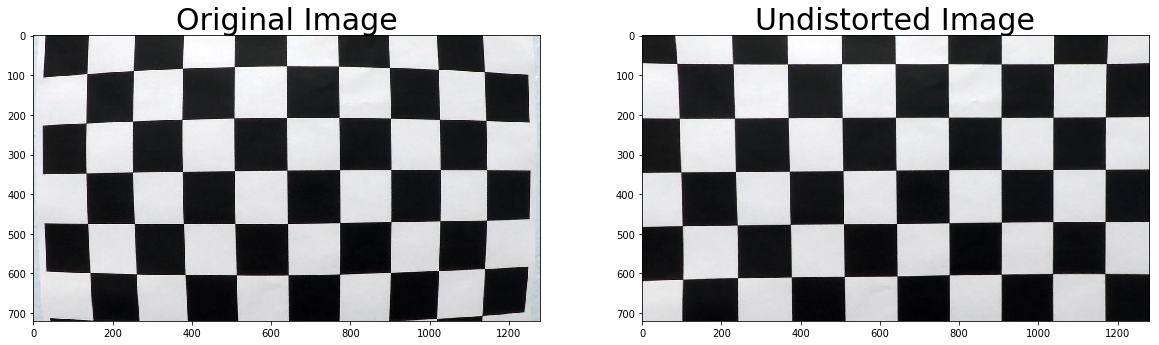

In [122]:
import pickle
%matplotlib inline

# Test undistortion on an image
file_path = os.getcwd()
file_path = file_path + '/camera_cal/calibration1.jpg'
img = cv2.imread(file_path)
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

file_path = os.getcwd()
file_path = file_path + '/output_images/calibration1_undist.jpg'
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite(file_path,dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_results.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Use color transforms, gradients, etc., to create a thresholded binary image.

In [441]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2+sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

In [546]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        abs_sobel = np.absolute(sobelx)

    else:
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        abs_sobel = np.absolute(sobely)

    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

In [654]:
def S_threshold(img, s_thresh):
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    return s_binary

In [655]:
def dir_threshold(img, sobel_kernel=3, abs_thres=(20), dir_thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    sobelx = np.absolute(sobelx)
    sobely = np.absolute(sobely)
    
    abs_sobel = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobel/np.max(abs_sobel))
    abs_sobel = np.absolute(sobely)
    scaled_sobely = np.uint8(255*abs_sobel/np.max(abs_sobel))

    sobelx[(scaled_sobelx<abs_thres)] = 0
    sobely[(scaled_sobely<abs_thres)] = 0

    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(sobely,sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

In [656]:
def R_threshold(img, r_thresh):
    R = img[:,:,0]
    
    r_binary = np.zeros_like(R)
    r_binary[(R > r_thresh[0]) & (R <= r_thresh[1])] = 1
    
    return r_binary

In [719]:
# Edit this function to create your own pipeline.
def image_threshold(img):
    #img = np.copy(img)

    
    # Sobel x
    #sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    #abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    #scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    #sxbinary = np.zeros_like(scaled_sobel)
    #sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    

    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    # color_binary_stack = np.dstack(( 150*np.ones_like(sxbinary), sxbinary, s_binary))
    
    mag_binary = np.uint8(mag_thresh(img, sobel_kernel=3, mag_thresh=(50, 255)))
    sobelx_binary = np.uint8(abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=255))
    #sobely_binary = np.uint8(abs_sobel_thresh(img, orient='y', thresh_min=30, thresh_max=255))
    dir_binary = np.uint8(dir_threshold(img, sobel_kernel=15, abs_thres=(20), dir_thresh=(np.pi/2-1,np.pi/2-0.2)))
 
    s_binary = np.uint8(S_threshold(img, s_thresh=(170, 255)))
    r_binary = np.uint8(R_threshold(img, r_thresh=(220, 255)))
    
    ch1_binary = cv2.bitwise_or(r_binary,r_binary)
    ch2_binary = mag_binary = (mag_binary)
    ch3_binary = mag_binary = (dir_binary)
    binary_stack = 255*np.dstack((ch1_binary, ch2_binary, ch3_binary))


    #color_binary_stack = np.array(255*color_binary_stack, dtype = np.float64)
    #s_binary = np.uint8(s_binary)
    #r_binary = np.uint8(r_binary)

    #color_binary = cv2.cvtColor(color_binary_stack,cv2.COLOR_GRAY2RGB)
    binary = np.zeros_like(s_binary)

    binary[(ch1_binary > 0) | (ch2_binary > 0) |(ch3_binary > 0)] = 255

    #color_binary = (binary_stack)
    
    return binary,binary_stack

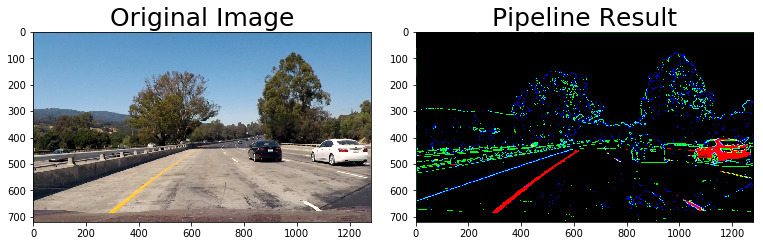

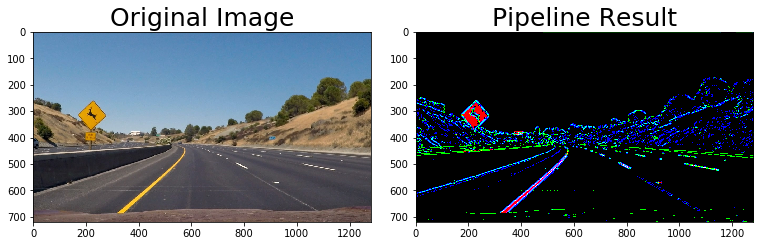

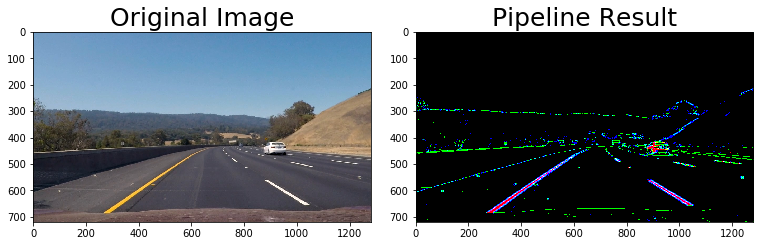

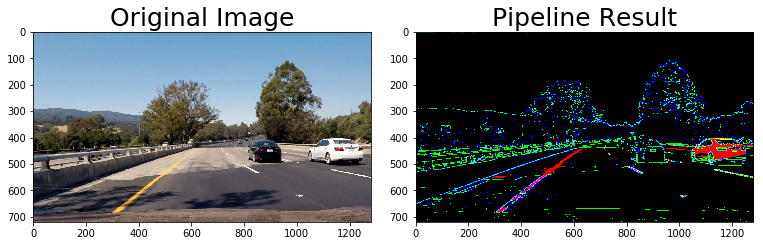

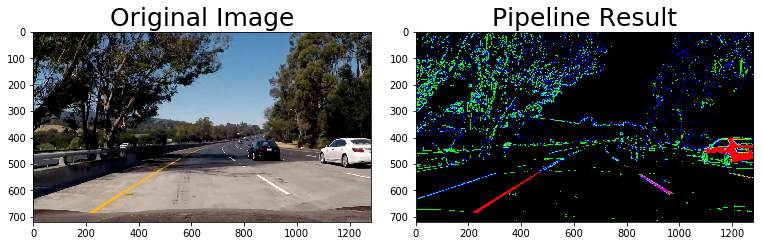

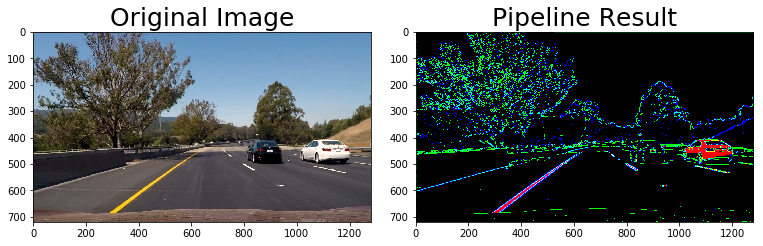

In [726]:
import matplotlib.image as mpimg
# Make a list of test images
file_path = os.getcwd()
file_path = file_path + '/test_images/test*.jpg'
images = glob.glob(file_path) 

i=0
for fname in images:    
    image = mpimg.imread(fname)
    res,result = image_threshold(image)
    
    i=i+1
    file_path = os.getcwd()
    file_path = file_path + '/output_images/' + 'binary' + str(i) + '.jpg'
    cv2.imwrite(file_path,res)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.tight_layout()

    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=25)

    ax2.imshow(result)
    ax2.set_title('Pipeline Result', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Apply a perspective transform to rectify binary image ("birds-eye view").

In [817]:
def image_unwarp(img):
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    
    # 4 destination points dst = np.float32([[,],[,],[,],[,]])
    src = np.float32([[580,450],[770,450],[1130,680],[220,680]])
    src = np.float32([[580,450],[770,450],[1320,680],[30,680]])
    src = np.float32([[650-70,450],[650+70,450],[650+600,680],[650-600,680]])
    #print(src)

    offset = 100 # offset for dst points
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                      [img_size[0]-offset, img_size[1]], 
                      [offset, img_size[1]]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    return warped,Minv


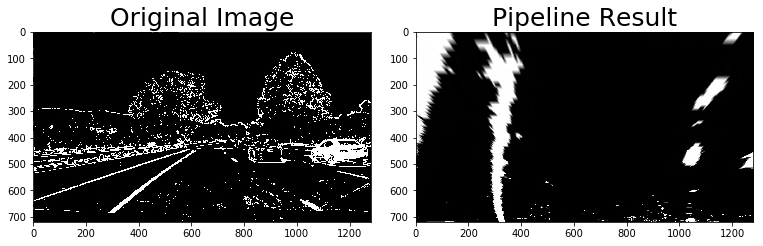

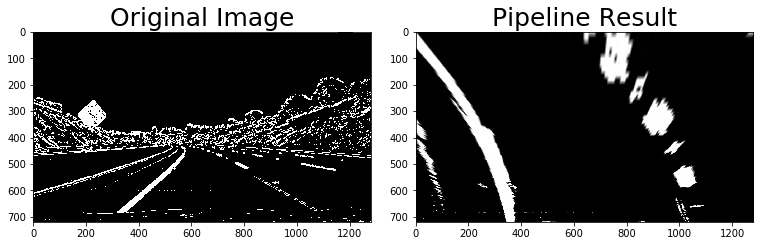

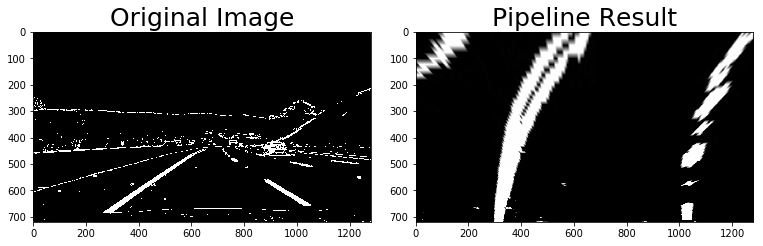

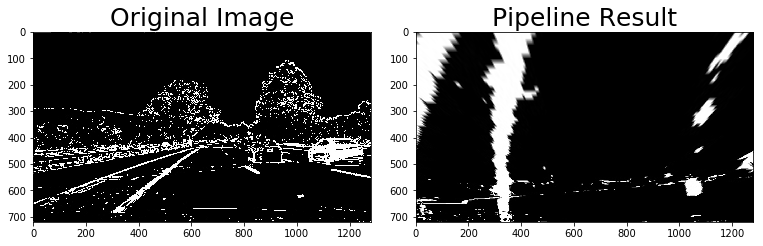

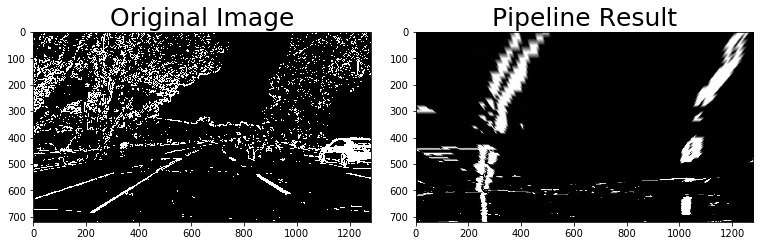

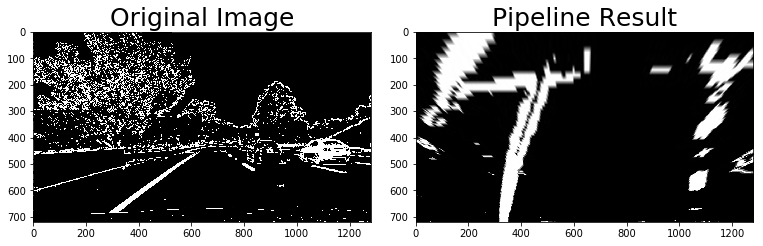

In [818]:
import matplotlib.image as mpimg
# Make a list of test images
file_path = os.getcwd()
file_path = file_path + '/output_images/binary*.jpg'
images = glob.glob(file_path) 

i=0
for fname in images:    
    image = mpimg.imread(fname)

    top_down,M = image_unwarp(image)

    i=i+1
    file_path = os.getcwd()
    file_path = file_path + '/output_images/' + 'warp' + str(i) + '.jpg'
    cv2.imwrite(file_path,top_down)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.tight_layout()

    image = np.array(cv2.merge((image,image,image)),np.uint8)
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=25)
    
    top_down = np.array(cv2.merge((top_down,top_down,top_down)),np.uint8)
    ax2.imshow(top_down)
    ax2.set_title('Pipeline Result', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Detect lane pixels and fit to find the lane boundary.

In [691]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

In [751]:
def find_window_centroids(warped, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
    return window_centroids

In [774]:
def detect_lanes(warped):

    # window settings
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching

    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channle 
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        
        output = cv2.addWeighted(warpage, 0.9, template, 0.5, 0.0) # overlay the orignal road image with window results

        i=0
        left_lane_x=[]
        left_lane_y=[]
        right_lane_x=[]
        right_lane_y=[]
        for centroids in window_centroids:
            left_lane_x.append(centroids[0])
            left_lane_y.append(warped.shape[0]-(i*window_height+window_height/2))
            right_lane_x.append(centroids[1])
            right_lane_y = left_lane_y
            i=i+1
        left_fit = np.polyfit(left_lane_y, left_lane_x, 2)
        right_fit = np.polyfit(right_lane_y, right_lane_x, 2)

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
        left_fit = []
        right_fit = []
    # Display the final results
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return output,ploty,left_fitx,right_fitx

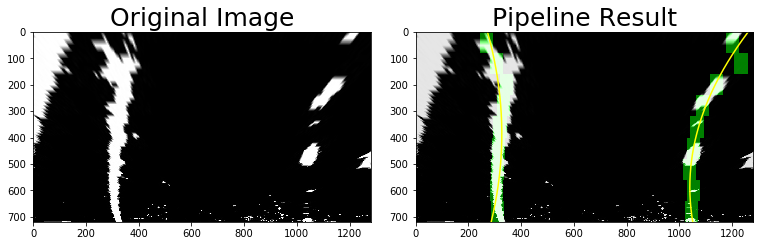

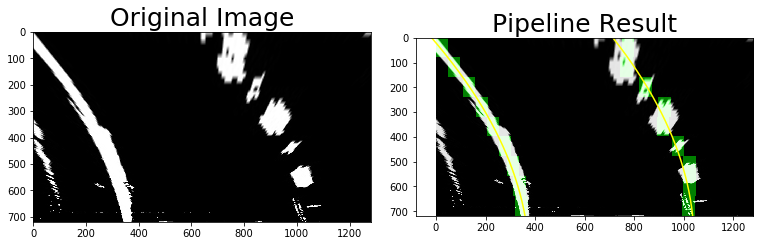

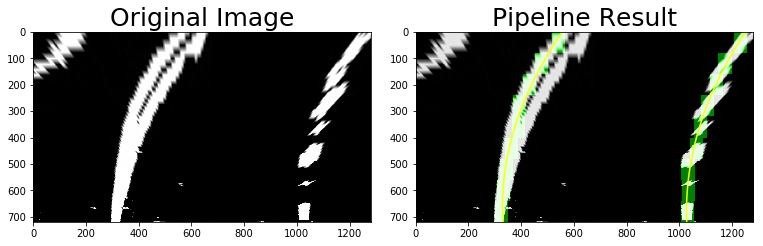

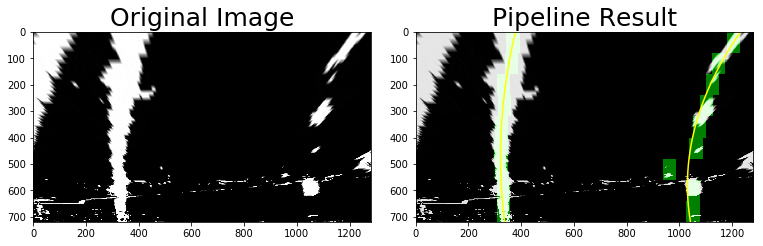

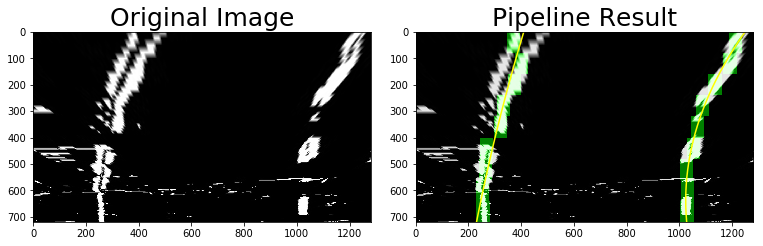

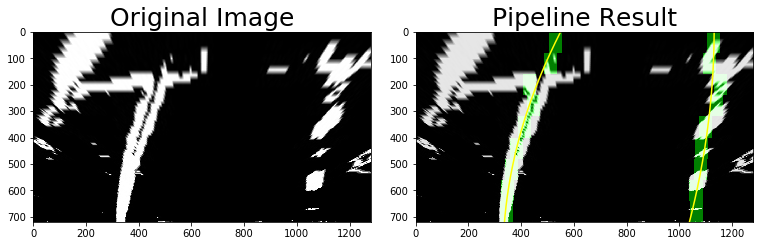

In [775]:
import matplotlib.image as mpimg
# Make a list of test images
file_path = os.getcwd()
file_path = file_path + '/output_images/warp*.jpg'
images = glob.glob(file_path) 

i=0
for fname in images:    
    image = mpimg.imread(fname)

    output,ploty,left_fitx,right_fitx = detect_lanes(image)

    i=i+1
    file_path = os.getcwd()
    file_path = file_path + '/output_images/' + 'detect' + str(i) + '.jpg'
    cv2.imwrite(file_path,output)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.tight_layout()

    image = np.array(cv2.merge((image,image,image)),np.uint8)
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=25)

    ax2.imshow(output)
    ax2.set_title('Pipeline Result', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

## Determine the curvature of the lane and vehicle position with respect to center.

1539.70649712 1540.49237509
505.398097373 m 505.857386336 m


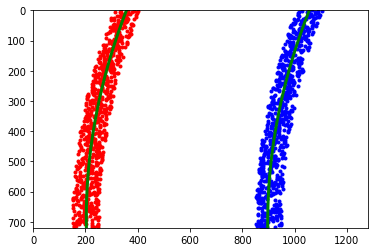

In [713]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

## Warp the detected lane boundaries back onto the original image.

In [812]:
def warp_back(warped,undist,M,ploty,left_fitx,right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [813]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [840]:
def process_image(img):
    undist = undistort_image(img, mtx, dist)
    img_binary, img_stack = image_threshold(undist)
    #warped,Minv = image_unwarp(img_binary)
    #output,ploty,left_fitx,right_fitx = detect_lanes(warped)
    #output = warp_back(warped,undist,Minv,ploty,left_fitx,right_fitx)
    #return output
    return img_binary

In [841]:
dist_pickle = pickle.load( open( "calibration_results.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

project_output = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(21,24)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4



 99%|█████████▊| 75/76 [00:17<00:00,  4.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 13.2 s, sys: 5.08 s, total: 18.3 s
Wall time: 19.1 s


In [842]:
HTML("""
<video width="500" height="300" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [611]:
## Challenge video

In [612]:
dist_pickle = pickle.load( open( "calibration_results.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

project_output = 'challenge_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")#.subclip(5,6)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video challenge_output.mp4
[MoviePy] Writing video challenge_output.mp4


100%|██████████| 485/485 [02:01<00:00,  4.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_output.mp4 

CPU times: user 1min 40s, sys: 29.2 s, total: 2min 9s
Wall time: 2min 2s


In [ ]:
HTML("""
<video width="500" height="300" controls>
  <source src="{0}">
</video>
""".format(challenge_output))